In [ ]:
import torch
import torch.nn as nn
import torch.optim as opt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models, datasets
from torchvision.models import VGG19_Weights
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

In [ ]:
!unzip -qq ./chip_data.zip -d data

replace data/dataset/test/defect/D2_C97.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
dataset_path = "./data/dataset"
train_dataset = datasets.ImageFolder(root=f"{dataset_path}/train", transform=transform)
test_dataset = datasets.ImageFolder(root=f"{dataset_path}/test", transform=transform)

In [ ]:
def show_sample_image(dataset, num_images = 5):
  fig, axes = plt.subplots(1, num_images, figsize=(5,5))
  for i in range(num_images):
    image, label = dataset[i]
    image = image.permute(1,2,0)
    axes[i].imshow(image)
    axes[i].set_title(dataset.classes[label])
    axes[i].axis('off')
  plt.show()

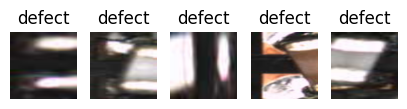

In [ ]:
show_sample_image(train_dataset)

In [ ]:
print(f"Total Number of training sample images: {len(train_dataset)}")

first_image, label = train_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total Number of training sample images: 172
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
print(f"Total Number of testing sample images: {len(test_dataset)}")

first_image, label = test_dataset[0]
print(f"Shape of the first image: {first_image.shape}")

Total Number of testing sample images: 121
Shape of the first image: torch.Size([3, 224, 224])


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model=models.vgg19(weights=VGG19_Weights.DEFAULT)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
model.classifier[-1]=nn.Linear(model.classifier[-1].in_features,1)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
for param in model.features.parameters():
  param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = opt.Adam(model.parameters(), lr=0.001)

In [ ]:
def train_model(model, train_loader, test_loader, num_epochs = 100):
  train_losses=[]
  val_losses=[]
  model.train()
  for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels.unsqueeze(1).float())
      loss.backward()
      optimizer.step()
      running_loss+=loss.item()
    train_losses.append(running_loss / len(train_loader))

    model.eval()
    val_loss=0.0
    with torch.no_grad():
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).float())
        val_loss+=loss.item()

    val_losses.append(val_loss / len(test_loader))
    model.train()

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")
  plt.figure(figsize=(10,5))
  plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss", marker='o')
  plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss", marker='s')
  plt.title("Training and Validation Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()
  print("NAME: SHYAM S")
  print("REGISTER.NO: 212223240156")

Epoch [1/100], Train Loss: 0.2857, Val Loss: 0.1699
Epoch [2/100], Train Loss: 0.0839, Val Loss: 1.1029
Epoch [3/100], Train Loss: 0.1283, Val Loss: 0.4271
Epoch [4/100], Train Loss: 0.1654, Val Loss: 0.2359
Epoch [5/100], Train Loss: 0.0209, Val Loss: 0.2096
Epoch [6/100], Train Loss: 0.0045, Val Loss: 0.2856
Epoch [7/100], Train Loss: 0.0233, Val Loss: 0.3057
Epoch [8/100], Train Loss: 0.0000, Val Loss: 0.1237
Epoch [9/100], Train Loss: 0.0001, Val Loss: 0.1461
Epoch [10/100], Train Loss: 0.0008, Val Loss: 0.1334
Epoch [11/100], Train Loss: 0.0002, Val Loss: 0.2791
Epoch [12/100], Train Loss: 0.0008, Val Loss: 0.1897
Epoch [13/100], Train Loss: 0.0001, Val Loss: 0.1934
Epoch [14/100], Train Loss: 0.0000, Val Loss: 0.2025
Epoch [15/100], Train Loss: 0.0000, Val Loss: 0.2105
Epoch [16/100], Train Loss: 0.0000, Val Loss: 0.2173
Epoch [17/100], Train Loss: 0.0000, Val Loss: 0.2148
Epoch [18/100], Train Loss: 0.0000, Val Loss: 0.1912
Epoch [19/100], Train Loss: 0.0000, Val Loss: 0.2119
Ep

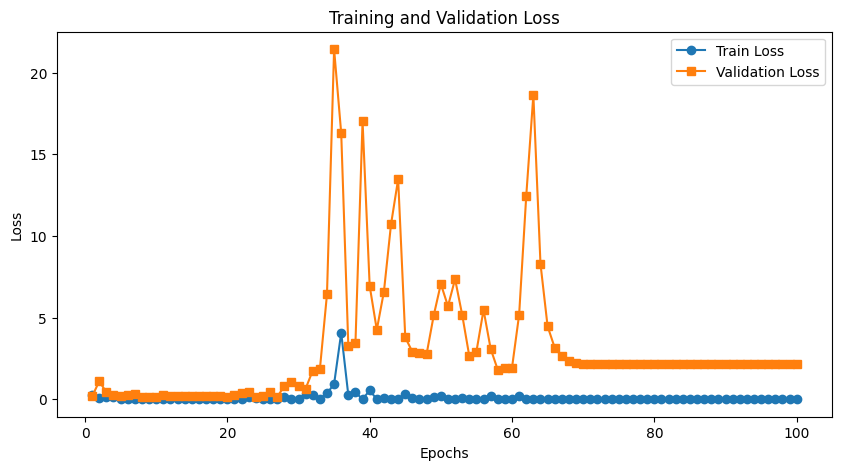

NAME: SHYAM S
REGISTER.NO: 212223240156


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

train_model(model, train_loader, test_loader)

In [ ]:
def test_model(model, test_loader):
  model.eval()
  correct = 0
  total = 0
  all_preds = []
  all_labels = []

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels in test_loader
      images = images.to(device)
      labels = labels.float().unsqueeze(1).to(device)

      outputs = model(images)
      probs = torch.sigmoid(outputs)
      preds = (probs > 0.5).float()

      total += labels.size(0)
      correct += (preds == labels.int()).sum().item()

      all_preds.extend(preds.cpu().numpy())
      all_labels.extend(labels.cpu().numpy().astype(int))

  accuracy = correct / total
  print(f"Test Accuracy: {accuracy:.4f}")


  class_names =['Negative', 'Positive']
  cm = confusion_matrix(all_labels, all_preds)
  print("NAME: SHYAM S")
  print("Register No: 212223240156")
  plt.figure(figsize=(8,6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  print("NAME: SHYAM S")
  print("Register No: 212223240156")
  print(classification_report(all_labels, all_preds, target_names=class_names))

Test Accuracy: 0.9669
NAME: SHYAM S
Register No: 212223240156


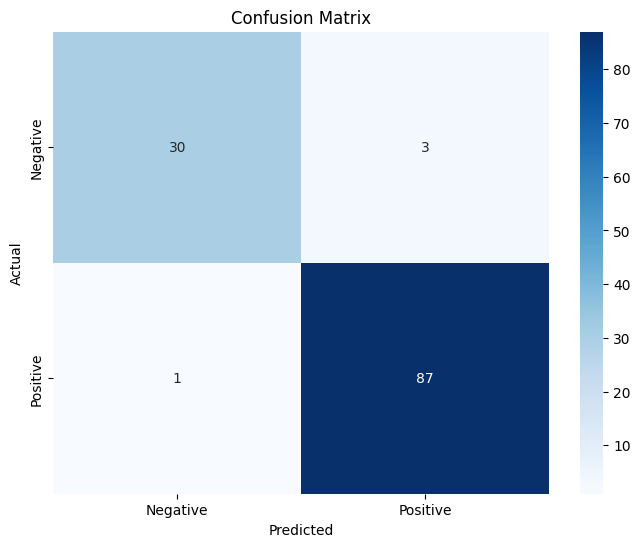

NAME: SHYAM S
Register No: 212223240156
              precision    recall  f1-score   support

    Negative       0.97      0.91      0.94        33
    Positive       0.97      0.99      0.98        88

    accuracy                           0.97       121
   macro avg       0.97      0.95      0.96       121
weighted avg       0.97      0.97      0.97       121



In [ ]:
test_model(model, test_loader)

In [ ]:
def predict_image(model, image_index, dataset):
  model.eval()
  image, label = dataset[image_index]
  with torch.no_grad():
    image_tensor = image.unsqueeze(0).to(device)
    output = model(image_tensor)
    _, predicted = torch.max(output, 1)
  class_names = dataset.classes

  image_to_display = transforms.ToPILImage()(image)
  print("NAME: SHYAM S")
  print("Register No: 212223240156")
  plt.figure(figsize=(5,5))
  plt.imshow(image_to_display)
  plt.title(f"Actual: {class_names[label]}\nPredicted: {class_names[predicted.item()]}")
  plt.axis("OFF")
  plt.show()

NAME: SHYAM S
Register No: 212223240156


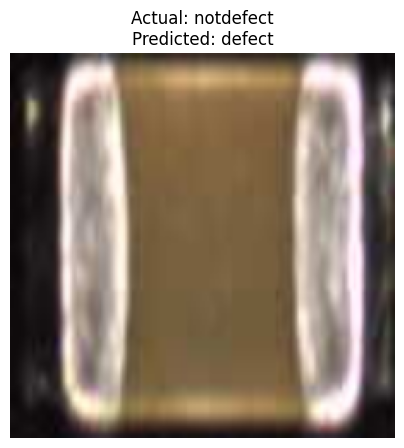

In [ ]:
predict_image(model, image_index=55, dataset=test_dataset)

NAME: SHYAM S
Register No: 212223240156


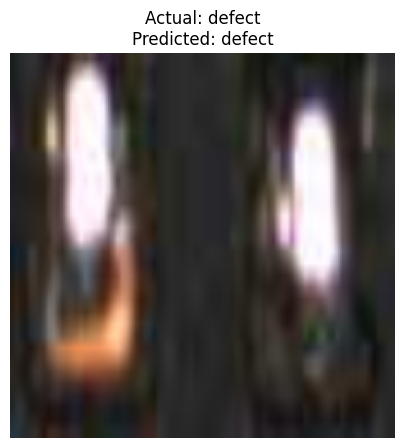

In [ ]:
predict_image(model,image_index=25, dataset=test_dataset)